In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scienceplots
import os
from matplotlib.lines import Line2D
from metrics import get_jsd, get_probkappa_mcqs, get_kappa_mcqs, get_adjkappa_mcqs, get_diffp, populate_preds, precomputed_accs, precomputed_diffs
# import statsmodels.api as sm 

In [2]:
preds_dict = {}
folder_name = "epochs_3"
model_names = ["weak_ft", "strong_base2", "w2s", "strong2"]
weak_models = ["gemma-2-2b", "Qwen2.5-1.5B", "Llama-3.2-3B", "phi-2"]
strong_models = ["gemma-2-9b", "Qwen2.5-7B", "Llama-3.1-8B"]
skip_list = [("gemma-2-9b", "Llama-3.1-8B"), ("Llama-3.1-8B", "gemma-2-9b"), ("Llama-3.1-8B", "Llama-3.1-8B"), ("Qwen2.5-0.5B", "OLMo-2-1124-7B"), ("Qwen2.5-0.5B", "Qwen2.5-14B"), ("Qwen2.5-0.5B", "gemma-2-27b"), ("Qwen2.5-0.5B", "granite-3.0-8b-base"), ("gemma-2-2b", "OLMo-2-1124-7B"), ("SmolLM-1.7B", "gemma-2-9b"), ("SmolLM-1.7B", "Qwen2.5-7B"), ("SmolLM-1.7B", "Llama-3.1-8B")]
datasets = ["anli-r2", "boolq", "cola", "ethics-utilitarianism", "sciq", "sst2", "twitter-sentiment", "dream", "mc_taco", "multirc", "quail", "quartz", "social_i_qa", "wic", "cosmos_qa"]

#iterate over folder names with ___ in results/{folder_name}
# for dir in os.listdir(f"results/{folder_name}"):
#     dir_path = f"results/{folder_name}/{dir}"
    # if os.path.isdir(dir_path) and "___" in dir:
    #     weak_model, strong_model = dir.split("___")
    #     if (weak_model, strong_model) in skip_list:
    #         continue
for weak_model in weak_models:
    for strong_model in strong_models:
        print(f"Models: {weak_model}, {strong_model}")
        # datasets = os.listdir(dir_path)
        # datasets = [d for d in datasets if d != "plots"]
        datasplits = ["val", "test"]
        preds = {}
        preds = populate_preds(preds, datasets, model_names, datasplits, folder_name, weak_model, strong_model)
        preds_dict[(weak_model, strong_model)] = preds        


Models: gemma-2-2b, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-1.5B, gemma-2-9b
Models: Qwen2.5-1.5B, Qwen2.5-7B
Models: Qwen2.5-1.5B, Llama-3.1-8B
Models: Llama-3.2-3B, gemma-2-9b
Models: Llama-3.2-3B, Qwen2.5-7B
Models: Llama-3.2-3B, Llama-3.1-8B
Models: phi-2, gemma-2-9b
Models: phi-2, Qwen2.5-7B
Models: phi-2, Llama-3.1-8B


In [3]:
# Updated loop to handle legend-based R^2 values
# skip_list = [("gemma-2-9b", "Llama-3.1-8B"), ("Llama-3.1-8B", "gemma-2-9b"), ("Llama-3.1-8B", "Llama-3.1-8B"), ("Qwen2.5-0.5B", "OLMo-2-1124-7B"), ("Qwen2.5-0.5B", "Qwen2.5-14B"), ("Qwen2.5-0.5B", "gemma-2-27b"), ("Qwen2.5-0.5B", "granite-3.0-8b-base"), ("gemma-2-2b", "OLMo-2-1124-7B")]
diffs_test = {}
diffmodw = "weak_ft"
diffmods = "strong_base2"
diff_split = "val"

for metric_func, metric_name in zip([get_jsd, get_probkappa_mcqs, get_kappa_mcqs, get_adjkappa_mcqs, get_diffp, _, _], ["JSD", "ProbKappa", "Kappa", "Adj2Kappa", "Prediction Diff%", "Accuracy Gap", "Mag Accuracy Gap"]):
    diffs_test[metric_name] = {}
    for (weak_model, strong_model), preds in preds_dict.items():
        if (weak_model, strong_model) in skip_list:
            continue
        if "Accuracy Gap" in metric_name:
            acc_test = {dset: precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, "test") for dset in datasets}
            acc_val = {dset: precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, diff_split) for dset in datasets}
            diffs_test[metric_name][(weak_model, strong_model)] = {dset: acc_val[dset][diffmods] - acc_val[dset][diffmodw] for dset in datasets}
            if "Mag" in metric_name:
                diffs_test[metric_name][(weak_model, strong_model)] = {dset: np.abs(v) for dset, v in diffs_test[metric_name][(weak_model, strong_model)].items()}
            continue
        print(weak_model, strong_model)
        diffs_test[metric_name][(weak_model, strong_model)] = {dset : precomputed_diffs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, diff_split, metric_func, metric_name, diffmodw, diffmods) for dset in datasets}

gemma-2-2b gemma-2-9b
gemma-2-2b Qwen2.5-7B
gemma-2-2b Llama-3.1-8B
Qwen2.5-1.5B gemma-2-9b
Qwen2.5-1.5B Qwen2.5-7B
Qwen2.5-1.5B Llama-3.1-8B
Llama-3.2-3B gemma-2-9b
Llama-3.2-3B Qwen2.5-7B
Llama-3.2-3B Llama-3.1-8B
phi-2 gemma-2-9b
phi-2 Qwen2.5-7B
phi-2 Llama-3.1-8B
gemma-2-2b gemma-2-9b
gemma-2-2b Qwen2.5-7B
gemma-2-2b Llama-3.1-8B
Qwen2.5-1.5B gemma-2-9b
Qwen2.5-1.5B Qwen2.5-7B
Qwen2.5-1.5B Llama-3.1-8B
Llama-3.2-3B gemma-2-9b
Llama-3.2-3B Qwen2.5-7B
Llama-3.2-3B Llama-3.1-8B
phi-2 gemma-2-9b
phi-2 Qwen2.5-7B
phi-2 Llama-3.1-8B
gemma-2-2b gemma-2-9b
gemma-2-2b Qwen2.5-7B
gemma-2-2b Llama-3.1-8B
Qwen2.5-1.5B gemma-2-9b
Qwen2.5-1.5B Qwen2.5-7B
Qwen2.5-1.5B Llama-3.1-8B
Llama-3.2-3B gemma-2-9b
Llama-3.2-3B Qwen2.5-7B
Llama-3.2-3B Llama-3.1-8B
phi-2 gemma-2-9b
phi-2 Qwen2.5-7B
phi-2 Llama-3.1-8B
gemma-2-2b gemma-2-9b
gemma-2-2b Qwen2.5-7B
gemma-2-2b Llama-3.1-8B
Qwen2.5-1.5B gemma-2-9b
Qwen2.5-1.5B Qwen2.5-7B
Qwen2.5-1.5B Llama-3.1-8B
Llama-3.2-3B gemma-2-9b
Llama-3.2-3B Qwen2.5-7B
Lla

In [4]:
# Example model short form dictionary
model_short_form = {
    "Llama-3.1-8B": "L-3.1-8b",
    "gemma-2-9b": "G-2-9b",
    "phi-2": "P-2-2.7b",
    "gemma-2-2b": "G-2-2b",
    "Qwen2.5-7B": "Q-2.5-7b",
    "Llama-3.2-3B": "L-3.2-3b",
    "Qwen2.5-1.5B": "Q-2.5-1.5b",
    "SmolLM-1.7B": "S-1-1.7b",
    # Add more models as needed
}

# Define the metrics you want to compute
metrics = {
    "JSD": get_jsd,
    "ProbKappa": get_probkappa_mcqs,
    "Kappa": get_kappa_mcqs,
    "Prediction Diff%": get_diffp
}

# The base DataFrame columns you requested
base_columns = [
    "WeakModel", "StrongModel", "Dataset",
    "StrongBaseAcc", "WeakFtAcc", "W2SAcc", "StrongFtAcc",
    "JSD", "ProbKappa", "Kappa", "AdjKappa", "DiffP", "MagGap", "AccGap"
]

data_records = []

In [5]:
# Build the unified DataFrame
for (weak_model, strong_model), preds in preds_dict.items():
    if (weak_model, strong_model) in skip_list:
        continue
    
    print(f"Processing Models: {weak_model}, {strong_model}")
    
    # Compute accuracy dict for each dataset
    acc_test = {
        dset: precomputed_accs(
            preds,
            f"{folder_name}/{weak_model}___{strong_model}",
            dset,
            model_names,
            "test"
        )
        for dset in datasets
    }
    
    # Compute metric values for each dataset
    # Assuming diffs_test is structured as: diffs_test[metric_name][(weak_model, strong_model)][dset]
    for dset in datasets:
        # Extract required accuracies
        strong_base_acc = acc_test[dset]["strong_base2"]
        weak_ft_acc = acc_test[dset]["weak_ft"]
        w2s_acc = acc_test[dset]["w2s"]
        strong_ft_acc = acc_test[dset]["strong2"]
        
        # Compute metrics
        # Make sure these metric functions accept the appropriate parameters.
        # Typically, they might need predictions or something similar.
        # Adjust the calls as needed based on how get_jsd, get_kappa_mcqs, get_diffp are defined.
        jsd_value = diffs_test["JSD"][(weak_model, strong_model)][dset]   # Example usage
        probkappa_value = diffs_test["ProbKappa"][(weak_model, strong_model)][dset]
        kappa_value = diffs_test["Kappa"][(weak_model, strong_model)][dset]
        adjkappa_value = diffs_test["Adj2Kappa"][(weak_model, strong_model)][dset]
        diffp_value = diffs_test["Prediction Diff%"][(weak_model, strong_model)][dset]
        maggap_value = diffs_test["Mag Accuracy Gap"][(weak_model, strong_model)][dset]
        accgap_value = diffs_test["Accuracy Gap"][(weak_model, strong_model)][dset]
        
        record = {
            "WeakModel": weak_model,
            "StrongModel": strong_model,
            "Dataset": dset,
            "StrongBaseAcc": strong_base_acc,
            "WeakFtAcc": weak_ft_acc,
            "W2SAcc": w2s_acc,
            "StrongFtAcc": strong_ft_acc,
            "JSD": jsd_value,
            "ProbKappa": probkappa_value,
            "Kappa": kappa_value,
            "AdjKappa": adjkappa_value,
            "DiffP": diffp_value,
            "MagGap": maggap_value,
            "AccGap": accgap_value
        }
        data_records.append(record)

df_base = pd.DataFrame(data_records, columns=base_columns)

# Now df_base is your unified DataFrame with all the requested base columns.
print(df_base.head())

Processing Models: gemma-2-2b, gemma-2-9b
Processing Models: gemma-2-2b, Qwen2.5-7B
Processing Models: gemma-2-2b, Llama-3.1-8B
Processing Models: Qwen2.5-1.5B, gemma-2-9b
Processing Models: Qwen2.5-1.5B, Qwen2.5-7B
Processing Models: Qwen2.5-1.5B, Llama-3.1-8B
Processing Models: Llama-3.2-3B, gemma-2-9b
Processing Models: Llama-3.2-3B, Qwen2.5-7B
Processing Models: Llama-3.2-3B, Llama-3.1-8B
Processing Models: phi-2, gemma-2-9b
Processing Models: phi-2, Qwen2.5-7B
Processing Models: phi-2, Llama-3.1-8B
    WeakModel StrongModel                Dataset  StrongBaseAcc  WeakFtAcc  \
0  gemma-2-2b  gemma-2-9b                anli-r2      58.233533  67.215569   
1  gemma-2-2b  gemma-2-9b                  boolq      70.452708  84.842361   
2  gemma-2-2b  gemma-2-9b                   cola      78.105590  81.832298   
3  gemma-2-2b  gemma-2-9b  ethics-utilitarianism      59.433509  72.587614   
4  gemma-2-2b  gemma-2-9b                   sciq      89.899329  89.194631   

      W2SAcc  StrongFt

Text(0, 0.5, 'Kappa')

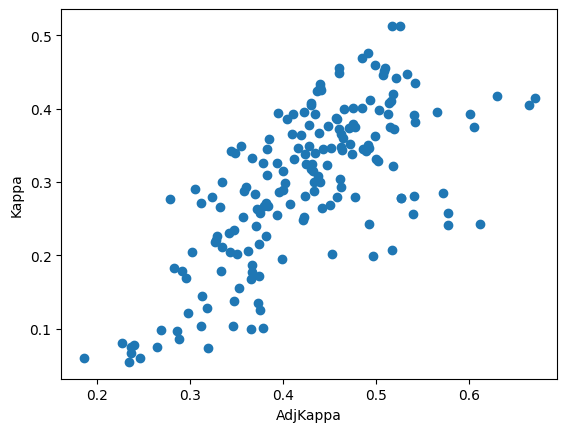

In [6]:
plt.scatter(df_base["AdjKappa"], df_base["Kappa"])
plt.xlabel("AdjKappa")
plt.ylabel("Kappa")

In [7]:
from matplotlib.patches import bbox_artist
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
from sklearn.calibration import column_or_1d
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr 

def create_weak_color_map(weak_models):
    """
    Assign fixed colors by model 'family' for the weak models.
    Fallback to a Husl palette for anything that doesn't match.
    """
    fallback_colors = sns.color_palette("husl", n_colors=len(weak_models))
    fallback_idx = 0
    
    color_map = {}
    for w in weak_models:
        w_lower = w.lower()
        if 'qwen' in w_lower:
            color_map[w] = (0.2, 0.2, 1.0)   # Light Blue
        elif 'llama' in w_lower:
            color_map[w] = (0.6, 1.0, 0.22)   # Light Green
        elif 'gemma' in w_lower:
            color_map[w] = (1.0, 0.6, 0.2)   # Light Orange
        else:
            # Fallback color
            if fallback_idx < len(fallback_colors):
                color_map[w] = fallback_colors[fallback_idx]
                fallback_idx += 1
            else:
                # If fallback colors are exhausted, assign a default light gray
                color_map[w] = (0.8, 0.8, 0.8)  # Light Gray

    return color_map

def plot_scatter(df, 
                 x_col, 
                 y_col, 
                 r_cols=None, 
                 groupby=None, 
                 hue_col="Dataset", 
                 annotate_modelpairs=False, 
                 model_short_form=None, 
                 x_col_name=None,
                 y_col_name=None,
                 add_scatter=True,
                 path=None,
                 no_legend=False  
                ):
    """
    Plot scatter of x_col vs. y_col with optional linear regression lines.
    
    If hue_col == 'Group':
      - Weak model => line color
      - Strong model => line style + marker
      - Compute Pearson r for each weak/strong pair
      - Show a *single legend* where each (line, marker) is side by side.
    
    Otherwise (hue_col != 'Group'):
      - Plot one overall regression + hue-based scatter
      - Show single correlation r for the entire dataset.
    """
    plt.figure(figsize=(8, 8))
    plt.style.use(['science', 'no-latex'])
    
    # =============== CASE 1: hue_col == 'Group' (Weak/Strong Models) ===============
    if hue_col == 'Group':
        # Split 'Group' into Weak/Strong model names
        df['WeakModel_Name'] = df['Group'].apply(lambda x: x.split('_')[0])
        df['StrongModel_Name'] = df['Group'].apply(lambda x: '_'.join(x.split('_')[1:]))
        
        # Unique sets
        weak_models = sorted(df['WeakModel_Name'].unique())
        strong_models = sorted(df['StrongModel_Name'].unique())
        
        # ----- COLORS for WEAK MODELS (by "family") -----
        weak_color_map = create_weak_color_map(weak_models)
        
        # Linestyles for strong models
        linestyles = ['-', '--', ':', '-.'] * (len(strong_models) // 4 + 1)
        strong_style_map = dict(zip(strong_models, linestyles[:len(strong_models)]))
        
        # Markers for strong models
        marker_styles = ['o', 's', 'd', '^', 'v'] * (len(strong_models) // 5 + 1)
        strong_marker_map = dict(zip(strong_models, marker_styles[:len(strong_models)]))
        
        group_data = []
        for label in df[hue_col].unique():
            label_df = df[df[hue_col] == label].copy()
            if len(label_df) < 2:
                continue
            
            # If r_cols given, compute residual
            if r_cols is not None:
                X_for_resid = label_df[r_cols]
                y_for_resid = label_df[y_col]
                reg_resid = LinearRegression().fit(X_for_resid, y_for_resid)
                label_df['Residual'] = y_for_resid - reg_resid.predict(X_for_resid)
            
            # Fit linear model & get Pearson r
            X = label_df[x_col].values.reshape(-1, 1)
            Y = label_df[y_col].values if r_cols is None else label_df['Residual'].values
            
            

            reg = LinearRegression().fit(X, Y)
            r_val, p_value = pearsonr(X.ravel(), Y)

            print(f"Group: {label}")
            print(f"  Coefficient for {x_col} p-value: {p_value:.4f}")
            
            weak_model = label.split('_')[0]
            strong_model = '_'.join(label.split('_')[1:])
            
            color = weak_color_map[weak_model]
            linestyle = strong_style_map[strong_model]
            marker = strong_marker_map[strong_model]
            
            group_data.append((weak_model, strong_model, color, linestyle, marker, reg, X, label_df, r_val))
        
        # Sort the group entries
        group_data.sort(key=lambda x: (x[0], x[1]))  # (weak_model, strong_model)
        
        # -- Plot lines --
        for (weak_model, strong_model, color, linestyle, marker, reg, X, label_df, r_val) in group_data:
            x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
            plt.plot(x_range, reg.predict(x_range),
                     color=color, linestyle=linestyle, alpha=1.0, linewidth=2)
        
        # -- Plot scatter points --
        if add_scatter:
            for (weak_model, strong_model, color, linestyle, marker, reg, X, label_df, r_val) in group_data:
                plt.scatter(label_df[x_col],
                            label_df[y_col] if r_cols is None else label_df['Residual'],
                            color=color, zorder=1, alpha=0.5, edgecolor='black', linewidth=0.5,
                            s=50, marker=marker)
        
        # -- Build a single legend with line+marker side by side --
        legend_handles = []
        legend_labels = []
        
        # We'll create two Line2D objects for each pair:
        #   1) the line style (no marker)
        #   2) the marker (no line)
        # Then combine them as a tuple and pass handler_map={tuple: HandlerTuple(...)} to legend
        for (weak_model, strong_model, color, linestyle, marker, _, _, _, r_val) in group_data:
            line = Line2D(
                [], [], 
                color=color,
                linestyle=linestyle,
                linewidth=2
            )
            marker_obj = Line2D(
                [], [], 
                color=color,
                marker=marker, 
                linewidth=0,
                markersize=8
            )
            label_text = f"{weak_model} - {strong_model} (r={r_val:.2f})"
            
            legend_handles.append((marker_obj, line))
            legend_labels.append(label_text)
        if not no_legend:
            plt.legend(
                legend_handles, 
                legend_labels,
                handler_map={tuple: HandlerTuple(ndivide=None)},  # side-by-side
                handlelength=3.0,         # <--- make the line snippet longer
                handletextpad=0.8,
                loc='upper right',
                frameon=True,
                edgecolor='black',
                title='Weak - Strong Markers & Lines',
                framealpha=0.7,
                fontsize=12,
                title_fontsize=14
            )
        
    # =============== CASE 2: hue_col != 'Group' ===============
    else:
        if r_cols is not None:
            X_for_resid = df[r_cols]
            y_for_resid = df[y_col]
            reg_resid = LinearRegression().fit(X_for_resid, y_for_resid)
            df['Residual'] = y_for_resid - reg_resid.predict(X_for_resid)
        
        # Single regression across entire dataset
        reg = sns.regplot(
            data=df, 
            x=x_col, 
            y=(y_col if r_cols is None else 'Residual'),
            scatter=False,
            ci=None, 
            line_kws={'linestyle': '--', 'alpha': 0.8, 'linewidth': 2}
        )
        
        # Compute overall Pearson r
        X = df[x_col].values.reshape(-1, 1)
        Y = df[y_col].values if r_cols is None else df['Residual'].values
        r_val, _ = pearsonr(X.ravel(), Y)
        print(f"{hue_col} overall r = {r_val:.2f}")
        
        # Scatter with hue
        if add_scatter:
            scatter = sns.scatterplot(
                data=df, 
                x=x_col, 
                y=(y_col if r_cols is None else 'Residual'),
                hue=hue_col,
                palette='husl', 
                s=50,
                zorder=1,
                alpha=0.5,
                edgecolor='black',
                linewidth=0.5
            )
        if no_legend:
            plt.legend().set_visible(False)
            plt.text(0.8, 0.9, f'r = {r_val:.2f}', transform=plt.gca().transAxes, fontsize=20, bbox=dict(facecolor='white', alpha=0.8))
        
        if not no_legend:   
            # Extract the legend
            handles, labels = plt.gca().get_legend_handles_labels()
            new_labels = [lab.replace('_','-') for lab in labels]
            
            # Create a standalone legend
            legend_fig = plt.figure(figsize=(10, 1))
            legend_ax = legend_fig.add_subplot(111)
            legend_ax.axis('off')
            legend = legend_fig.legend(
                handles=handles,
                labels=new_labels,
                labelspacing=0.3,
                loc='center',
                fontsize=16,
                title_fontsize=18,
                framealpha=0.5,
                edgecolor='black',
                frameon=True,
                ncol=len(handles) // 2 + 1,
                handletextpad=0.1,
                columnspacing=0.2
            )
            legend.get_frame().set_linewidth(1)
            
            # Save the legend as a separate image
            legend_fig.savefig(path, dpi=300, bbox_inches='tight')
            legend_fig.show()
     # ------ Plot formatting -------
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlabel(f'{x_col_name}', fontsize=20, fontweight='bold')
    if r_cols is None:
        plt.ylabel(f'{y_col_name}', fontsize=20, fontweight='bold')
    else:
        plt.ylabel('Residual (Gain - Predicted)', fontsize=20, fontweight='bold')
    
    # plt.title(f"{x_col_name} vs. {y_col_name}", fontsize=20, fontweight='bold', pad=20)
    # plt.text(0.8, 0.9, f'r = {r_val:.2f}', transform=plt.gca().transAxes, fontsize=20, bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout()
    if path is not None:
        plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()
    


Group: gemma-2-2b_gemma-2-9b
  Coefficient for ProbKappa p-value: 0.0001
Group: gemma-2-2b_Qwen2.5-7B
  Coefficient for ProbKappa p-value: 0.0000
Group: gemma-2-2b_Llama-3.1-8B
  Coefficient for ProbKappa p-value: 0.0044
Group: Qwen2.5-1.5B_gemma-2-9b
  Coefficient for ProbKappa p-value: 0.0003
Group: Qwen2.5-1.5B_Qwen2.5-7B
  Coefficient for ProbKappa p-value: 0.0000
Group: Qwen2.5-1.5B_Llama-3.1-8B
  Coefficient for ProbKappa p-value: 0.0042
Group: Llama-3.2-3B_gemma-2-9b
  Coefficient for ProbKappa p-value: 0.0000
Group: Llama-3.2-3B_Qwen2.5-7B
  Coefficient for ProbKappa p-value: 0.0000
Group: Llama-3.2-3B_Llama-3.1-8B
  Coefficient for ProbKappa p-value: 0.0010
Group: phi-2_gemma-2-9b
  Coefficient for ProbKappa p-value: 0.0000
Group: phi-2_Qwen2.5-7B
  Coefficient for ProbKappa p-value: 0.0000
Group: phi-2_Llama-3.1-8B
  Coefficient for ProbKappa p-value: 0.0046


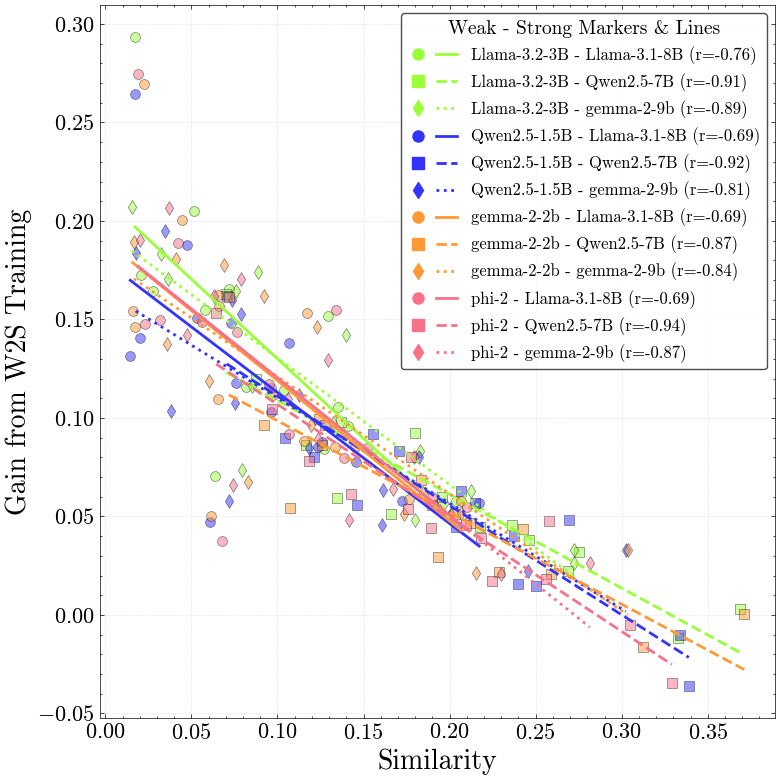

In [8]:
df_base['W2SGain'] = df_base['W2SAcc'] - df_base['StrongBaseAcc']  # dependent variable
df_base['Group'] = df_base['WeakModel'] + '_' + df_base['StrongModel']
df_base['W2SGain'] /= 100.0  # Scale to 0-1 range
df_base['JSDinv'] = 1.0 - df_base['JSD']  # Invert JSD for better correlation
x_col_name = 'Similarity'
y_col_name = 'Gain from W2S Training'
path = 'kappavsgain.pdf'
# 4. Plot with your existing plot_scatter function
plot_scatter(
    df_base,
    x_col='ProbKappa',
    y_col='W2SGain',   # <-- use the residuals as y
    # r_cols=['AccGap'],
    groupby=True,
    hue_col='Group',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    x_col_name=x_col_name, 
    y_col_name=y_col_name,
    path=path,
    no_legend=False
)

In [10]:
#compute partial correlation
import pingouin as pg
pcorr = pg.partial_corr(data=df_base, x='ProbKappa', y='W2SGain', covar='AccGap', method='pearson')
print(pcorr)

           n         r           CI95%     p-val
pearson  180 -0.350757  [-0.47, -0.22]  0.000001
